In [2]:
import shap
import polars as pl
import pandas as pd
import logging
import numpy as np
from joblib import load
import argparse
import logging
import os

In [3]:
# Read training data
# Read training data, adapted from 11_generate_models.py
class Args:
    training_file = "data/all_gene_annotations.added_incompleteness_and_contamination.training.tsv"
    y = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv"
    model = "data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv.models/XGBoost.model"

args = Args()

# Read y
y0 = pl.read_csv(args.y, separator="\t")
y1 = y0.unique() # There are some duplicates in the cyanos, so dedup
logging.info("Read y: %s", y1.shape)
# Log counts of each class
logging.info("Counts of each class amongst unique accessions: %s", y1.groupby("oxytolerance").agg(pl.count()))

# Read GTDB
gtdb = pl.concat([
    pl.read_csv('data/bac120_metadata_r202.tsv', separator="\t"),
    pl.read_csv('data/ar122_metadata_r202.tsv', separator="\t")
])
gtdb = gtdb.filter(pl.col("gtdb_representative") == "t")
logging.info("Read in {} GTDB reps".format(len(gtdb)))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(1).alias("phylum"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(2).alias("class"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(3).alias("order"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(4).alias("family"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').arr.get(5).alias("genus"))

# Read training data
d = pl.read_csv(args.training_file,separator="\t")
logging.info("Read training data: %s", d.shape)

# Ignore all but training data
d2 = d.join(gtdb.select(['accession','phylum','class','order','family','genus']), on="accession", how="left")
d3 = d2.join(y1, on="accession", how="inner") # Inner join because test accessions are in y1 but not in d2
logging.info("Counts of each class in training/test data: %s", d3.groupby("oxytolerance").agg(pl.count()))

X = d3.select(pl.exclude(['accession','oxytolerance','phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()
# Map oxytolerance to 0, 1, 2
if 'anaerobic_with_respiration_genes' in d3['oxytolerance'].to_list():
    classes_map = {
        'anaerobe': 0,
        'aerobe': 1,
        'anaerobic_with_respiration_genes': 2,
    }
else:
    classes_map = {
        'anaerobe': 0,
        'aerobe': 1,
    }

y = d3.select(pl.col('oxytolerance').apply(lambda x: classes_map[x]).alias('oxytolerance'))
logging.info("Counts of y: %s", y.groupby("oxytolerance").agg(pl.count()))
y = y.to_pandas()

groups = d3['family'].to_list()

d_gtdb = d3.to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X = X.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'],axis=1)

In [4]:
model = load(args.model)
model

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=64, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

# Load KEGG names

In [5]:
modal_keggs = pd.read_csv('data/modal_keggs_with_names.csv',sep="\t")
modal_keggs.index = modal_keggs['cog']
# modal_keggs

In [6]:
columns2 = pd.Series(['{} {} {}'.format(cog, ko, ko_name) for cog, ko, ko_name in zip(modal_keggs.loc[X.columns,'cog'], modal_keggs.loc[X.columns,'ko'], modal_keggs.loc[X.columns,'ko_name'])])
dup_columns = columns2.duplicated()
columns2 = ["{}_{}".format(c,i) if is_dup else c for c,i,is_dup in zip(columns2, range(len(columns2)), dup_columns)]
# for 
# X_pred_scaled
# Ensure column names are unique
# and don't contain  [, ] or <
kos_and_names_column_names = [c.replace('[', '').replace(']', '').replace('<', '_') for c in columns2]

In [7]:
pred = model.predict(X)

In [8]:
pd.Series(pred).value_counts()

1    58376
0    29788
Name: count, dtype: int64

In [9]:
explainer = shap.TreeExplainer(model.steps[1][1])

X_pred_scaled = pd.DataFrame(model.steps[0][1].transform(X), columns=X.columns)
X_pred_scaled.columns = kos_and_names_column_names

shap_values = explainer.shap_values(X_pred_scaled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


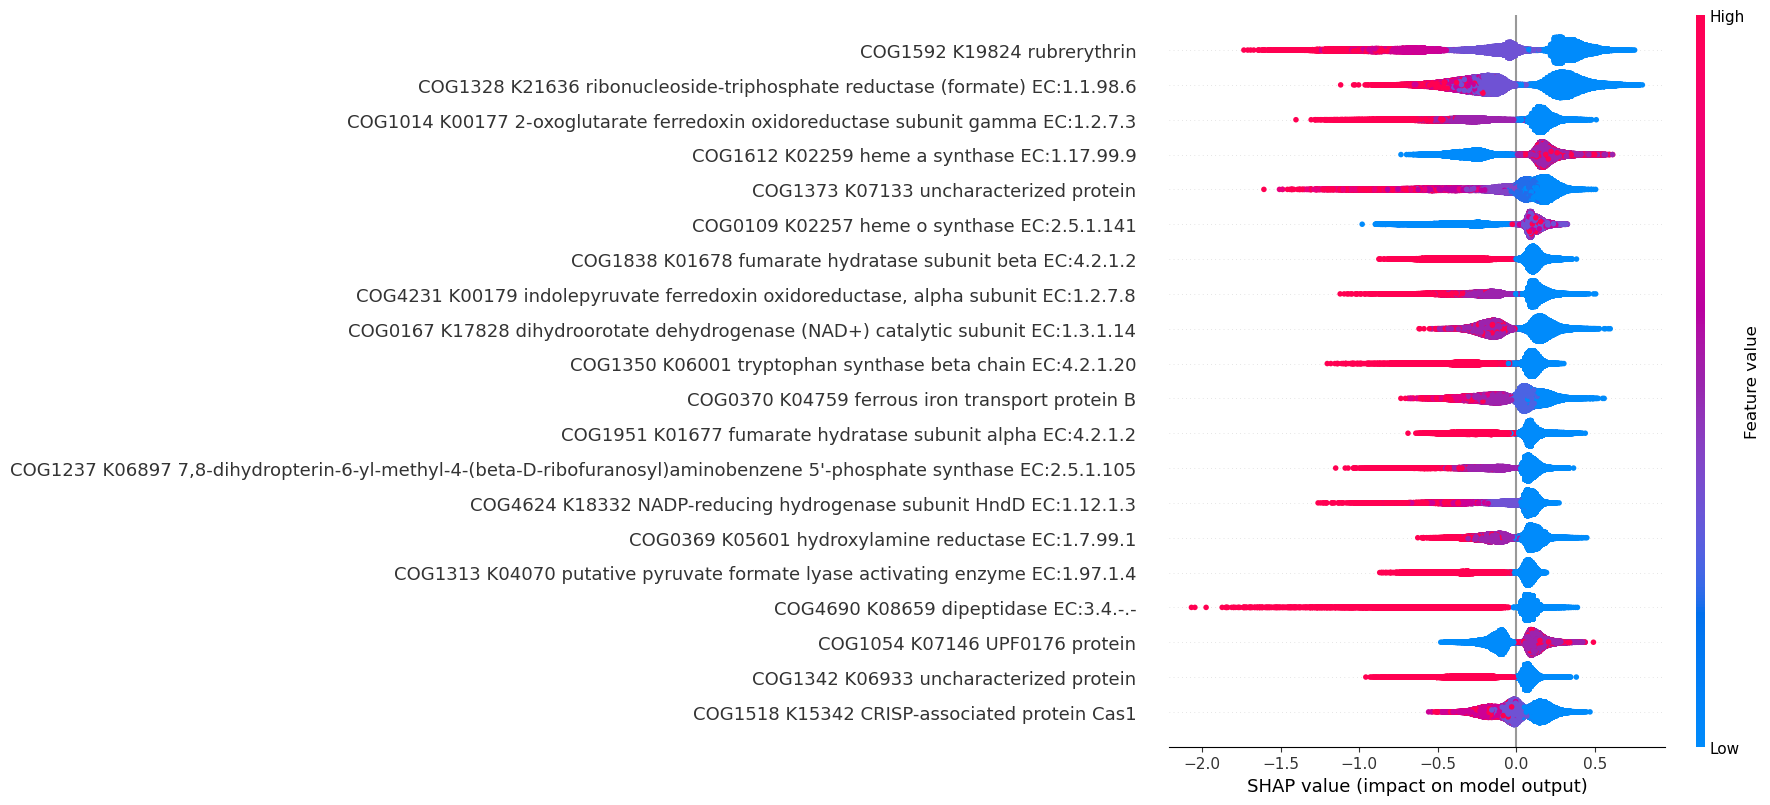

In [10]:
shap.summary_plot(shap_values, X_pred_scaled)

# And on the ancestral predictions, any different?

In [11]:
# modified from 13_apply.py
class Args2:
    x = 'data/TableAncestralRoot1.tsv'
    training_data_header = 'data/all_gene_annotations.added_incompleteness_and_contamination.testing.tsv'
args = Args2()

d = pd.read_csv(args.x, sep="\t")
logging.info("Read in input data of shape {}".format(d.shape))

# Collapse counts of each COG subfamily
d2 = d
d2['COG'] = d2['COG'].str.split('_').str[0]
d3 = d2.groupby('COG').sum()
d4 = d3.transpose()

# Read training data header
eg_data = pl.read_csv(args.training_data_header, separator="\t", has_header=True)
header = eg_data.select(pl.exclude([
    'accession','false_negative_rate','false_positive_rate'
])).columns
# Blacklist these as they aren't in the current ancestral file, not sure why
header = list([h for h in header if h not in ['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177']])

# Reorder columns to be the same as the training dataset
d5 = d4[header]

In [12]:
pred = model.predict(d5)

explainer = shap.TreeExplainer(model.steps[1][1])

X_pred_scaled = pd.DataFrame(model.steps[0][1].transform(d5), columns=d5.columns)
X_pred_scaled.columns = kos_and_names_column_names

shap_values = explainer.shap_values(X_pred_scaled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


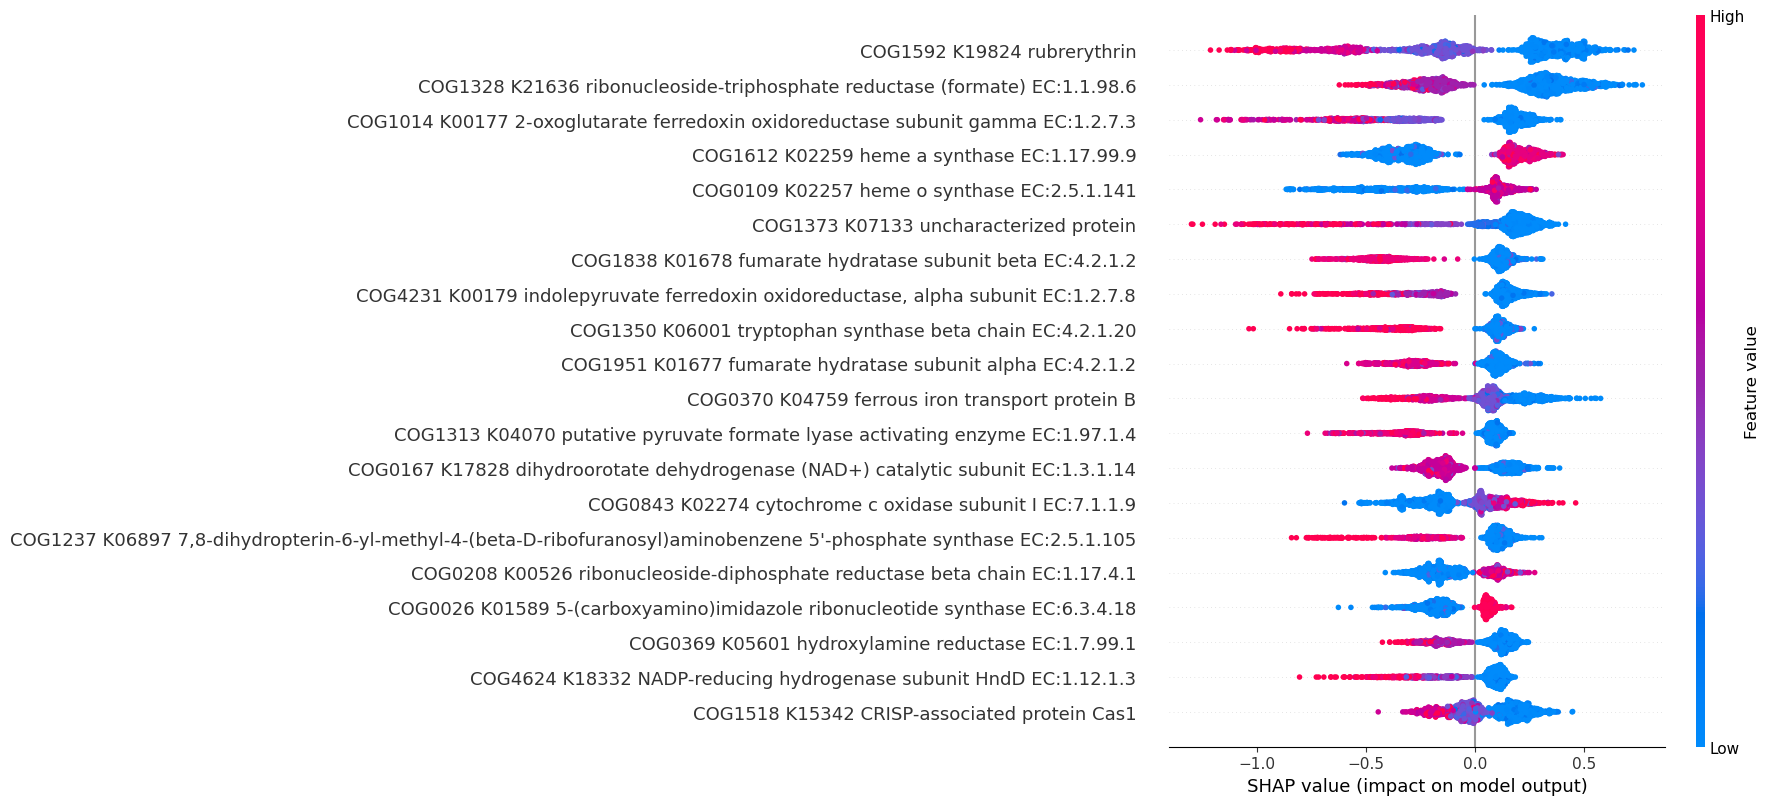

In [13]:
shap.summary_plot(shap_values, X_pred_scaled)

In [14]:
X_pred_scaled.loc[1963,:]

COG0001 K01845 glutamate-1-semialdehyde 2,1-aminomutase EC:5.4.3.8                      0.145455
COG0002 K00145 N-acetyl-gamma-glutamyl-phosphate reductase EC:1.2.1.38                  0.032000
COG0003 K01551 arsenite/tail-anchored protein-transporting ATPase EC:7.3.2.7 7.3.-.-    0.068889
COG0004 K03320 ammonium transporter, Amt family                                         0.090000
COG0005 K00772 5'-methylthioadenosine phosphorylase EC:2.4.2.28                         0.328000
                                                                                          ...   
COG5640 K09640 transmembrane protease serine 9 EC:3.4.21.-                              0.000000
COG5643 K11261 formylmethanofuran dehydrogenase subunit E EC:1.2.7.12                   0.000000
COG5650 K13671 alpha-1,2-mannosyltransferase EC:2.4.1.-                                 0.001000
COG5652 K20950 polysaccharide biosynthesis protein VpsQ                                 0.010000
COG5663 K05967 uncharacterized

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


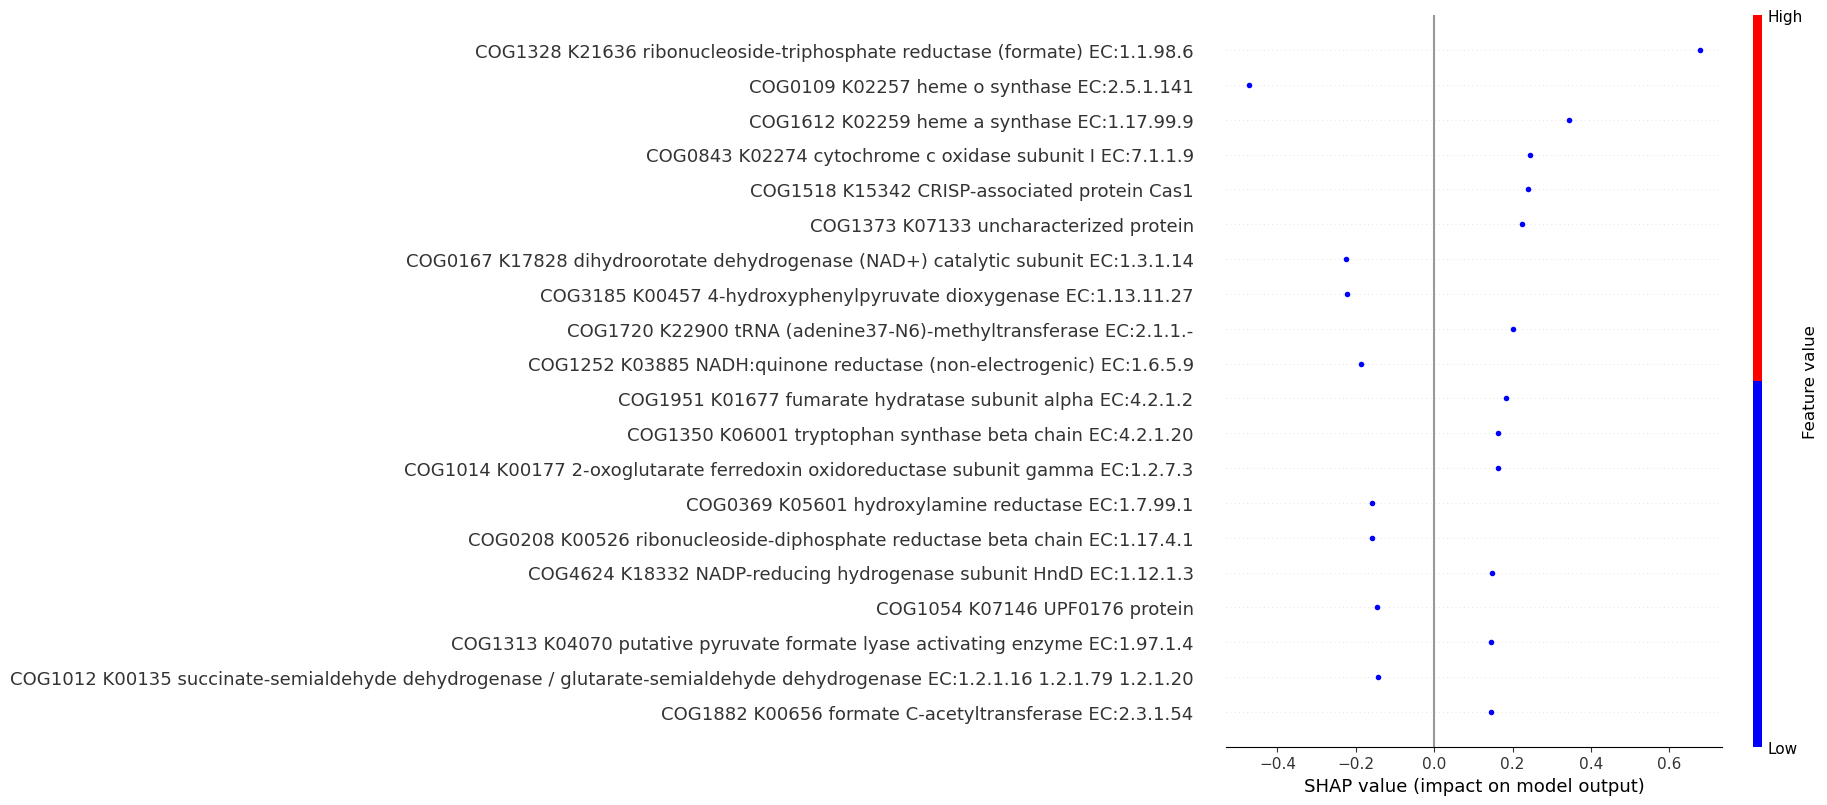

In [15]:
import matplotlib
my_colourmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red"], N=2)
shap.summary_plot(shap_values[[1963],:], X_pred_scaled.loc[[1963],:], cmap=my_colourmap)

In [16]:
print([c for c in X_pred_scaled.columns if 'COG0843' in c])
X_pred_scaled.loc[1963,'COG0843 K02274 cytochrome c oxidase subunit I EC:7.1.1.9']
X.loc[1963,'COG0843']
# X

['COG0843 K02274 cytochrome c oxidase subunit I EC:7.1.1.9']


3

# Total set of SHAP values

In [17]:
print(np.abs(shap_values).shape)
aggs = np.abs(shap_values).mean(0)
aggs

(2013, 2672)


array([0.02878117, 0.        , 0.00159735, ..., 0.        , 0.00060983,
       0.        ], dtype=float32)

In [65]:
# Want 
# 1. COG
# 2. COG descriptive name
# 3. mean absolute SHAP value
# 4. mean absolute SHAP for aerobe predictions
# 5. mean absolute SHAP for anaerobe predictions

# preds_and_shaps = pl.concat([
#     pl.DataFrame({
#     'pred': pred,}),
#     pl.DataFrame(shap_values),], how='horizontal')
# preds_and_shaps.columns = ['pred'] + list(X_pred_scaled.columns)

# # preds_and_shaps.groupby('pred').apply(lambda x: pl.Series(np.abs(x).mean(0)))
aerobe_shaps = shap_values[pred==1]
anaerobe_shaps = shap_values[pred==0]
# d5.iloc[pred==1,:].mean(0)
shap_df = pl.DataFrame({
    'cog': list(X.columns),
    'description': list(X_pred_scaled.columns),
    'mean absolute SHAP': aggs,
    'mean aerobe SHAP': aerobe_shaps.mean(0),
    'mean anaerobe SHAP': anaerobe_shaps.mean(0),
    'mean aerobe copy number': d5.iloc[pred==1, :].mean(0),
    'mean anaerobe copy number': d5.iloc[pred==0, :].mean(0),
    'median aerobe copy number': d5.iloc[pred==1, :].median(0),
    'median anaerobe copy number': d5.iloc[pred==0, :].median(0),
})
# sort this polars df by mean absolute SHAP
shap_df = shap_df.sort('mean absolute SHAP', descending=True)
shap_df.write_csv('data/xgboost_shap_values.csv', separator="\t")
shap_df.head(5)

cog,description,mean absolute SHAP,mean aerobe SHAP,mean anaerobe SHAP,mean aerobe copy number,mean anaerobe copy number,median aerobe copy number,median anaerobe copy number
str,str,f32,f32,f32,f64,f64,f64,f64
"""COG1592""","""COG1592 K19824…",0.382531,0.239496,-0.19903,0.254014,1.219062,0.01,1.0
"""COG1328""","""COG1328 K21636…",0.31368,0.31882,0.008559,0.098498,0.7656,0.0,1.0
"""COG1014""","""COG1014 K00177…",0.303175,0.167736,-0.241935,0.065872,1.228922,0.0,1.0
"""COG1612""","""COG1612 K02259…",0.280501,0.092665,-0.269761,0.906032,0.127914,1.0,0.0
"""COG0109""","""COG0109 K02257…",0.254237,0.054919,-0.28493,1.005849,0.278484,1.0,0.0
